# Assignment 4

In this assignment, you will be using SARIMA and LSTM models on univariate time series, and LSTM on multivariate time series.

* [0. Introduction](#h0)  

* [1. Univariate time series: SARIMA](#h1)  

* [2. Univariate time series: LSTM](#h2)  

* [3. Multivariate time series: LSTM](#h3)  
 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%cd gdrive/My\ Drive/Colab\ Notebooks/hw4

## 0. Introduction <a name="h0"></a>

In this homework, we will model temporal trends on sales price of items from a grocery store. There are 50 items from 10 locations. We will first look at univariate temporal trends, which means that only one item from one location is picked. Both time series and deep learning models will be evaluated. Then we will run a multivariate model to see whether more data can improve the prediction or not.    

## 1. Univariate time series: SARIMA <a name="h1"></a>





In this section, we only focus on the temporal trend of sales of item 1 from store 1. First, you need to upgrade `statsmodels` to perform seasonality decomposition. Be sure to restart runtime to load the latest `statsmodels`

In [ ]:
!pip install --upgrade statsmodels

In [ ]:
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
import math

color = sns.color_palette()
sns.set_style('darkgrid')

# save me from using display function every time I have multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Download data from [GitHub](https://github.com/yuankaihuo/DL_course_hw/tree/master/Homework%202/data) and save them on your drive

In [ ]:
# load data
train_data = pd.read_csv("data/train.csv",parse_dates=['date'])

# focus on 1 store and 1 item
train_data = train_data[(train_data['store']==1) & (train_data['item']==1)] # 1460 by 4

train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.dayofyear
train_data['weekday'] = train_data['date'].dt.weekday

# make training and validation sets 
days = train_data.shape[0]
train_df = train_data.iloc[:(days - 90),:] # 3 years and 9 months
validate_df = train_data.iloc[-90:,:] # last 90 days

print("The training set has " + str(train_df.shape[0]) +" rows, and " + str(train_df.shape[1]) + " columns.")
print("The validation set has " + str(validate_df.shape[0]) +" rows, and " + str(validate_df.shape[1]) + " columns.")

The training set has 1370 rows, and 8 columns.
The validation set has 90 rows, and 8 columns.


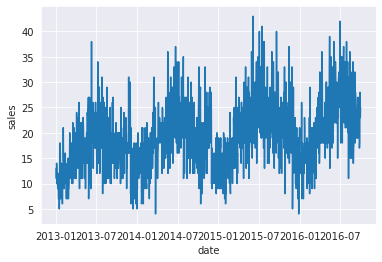

In [ ]:
# full temporal trend
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)
plt.show()

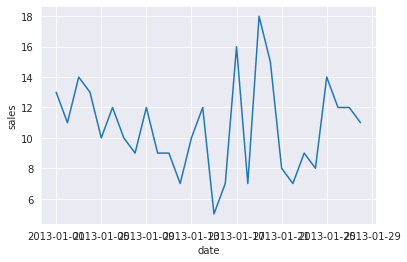

In [ ]:
# temporal trend of first 28 days
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])
plt.show()

### Seasonality decomposition

<Figure size 432x288 with 0 Axes>

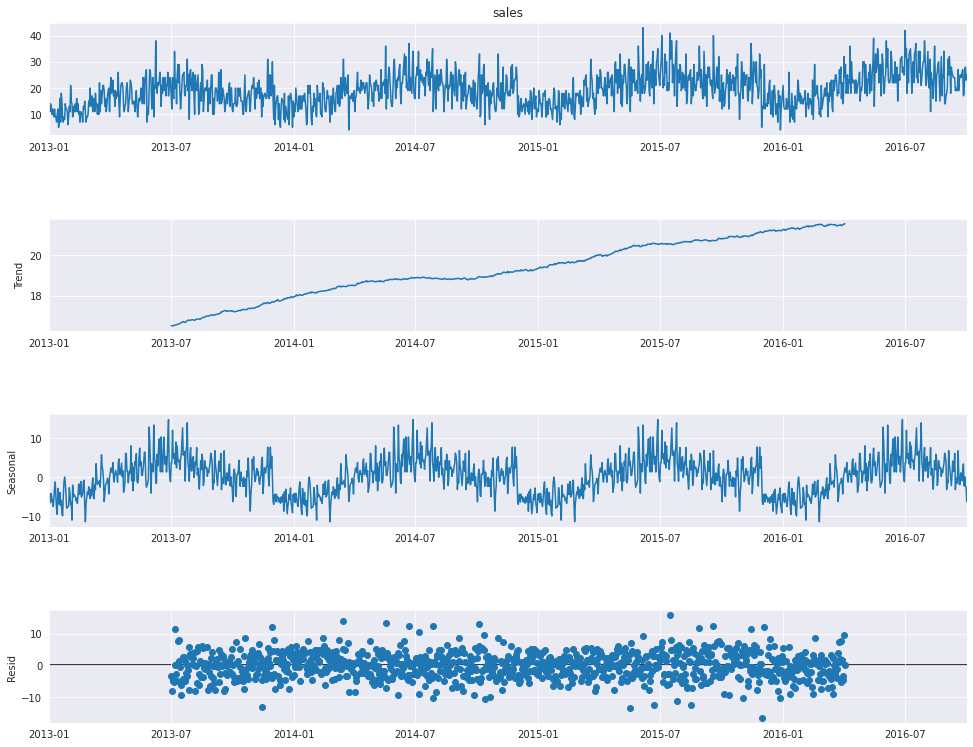

In [ ]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)
validate_df = validate_df.set_index('date')
validate_df['sales'] = validate_df['sales'].astype(float)

result = seasonal_decompose(train_df['sales'], model='additive',period=365)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 12)
plt.show()


### Stationarity test

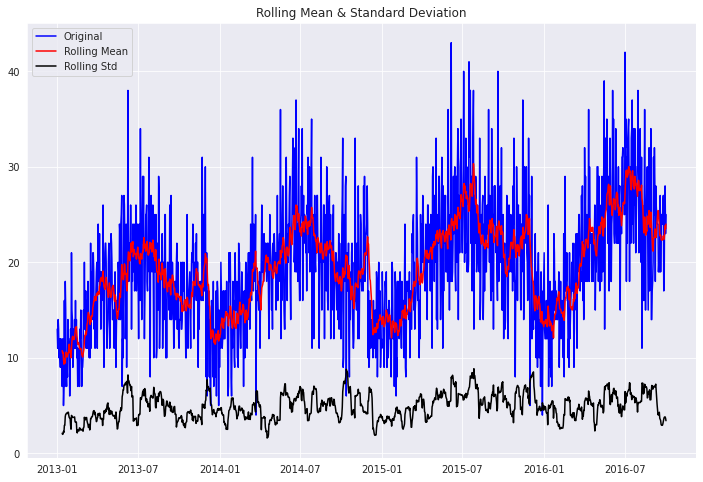

Results of Dickey-Fuller Test:
p-value = 0.0984. The series is likely non-stationary.
Test Statistic                   -2.574274
p-value                           0.098432
#Lags Used                       20.000000
Number of Observations Used    1349.000000
Critical Value (1%)              -3.435207
Critical Value (5%)              -2.863685
Critical Value (10%)             -2.567912
dtype: float64


In [ ]:
def test_stationarity(timeseries, window=12, cutoff=0.01):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag=20)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

    print(dfoutput)

test_stationarity(train_df['sales'])

Since it's non-stationary, we need to apply differencing to the series.

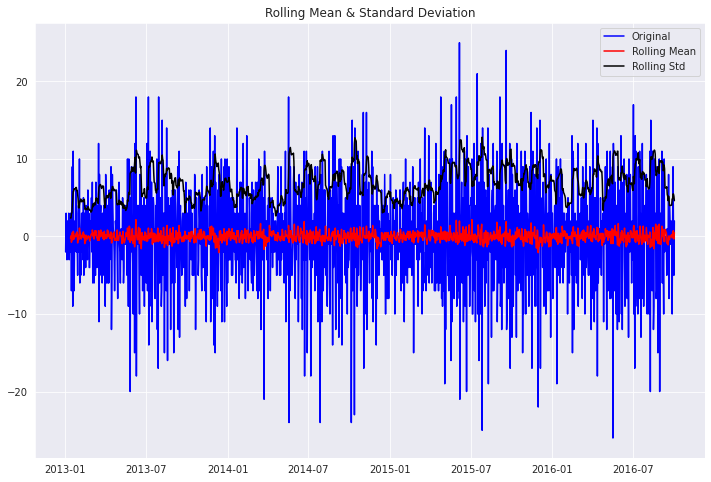

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.350903e+01
p-value                        2.877442e-25
#Lags Used                     1.900000e+01
Number of Observations Used    1.349000e+03
Critical Value (1%)           -3.435207e+00
Critical Value (5%)           -2.863685e+00
Critical Value (10%)          -2.567912e+00
dtype: float64


In [ ]:
# differencing
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

Now it looks very good. Remember that we did first order differencing.
How about ACF and PACF? First, original data: 

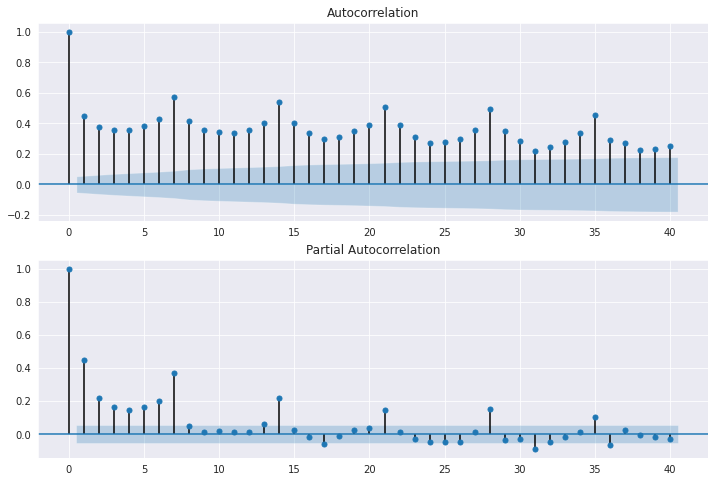

In [ ]:
 # plot acf and pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1) #
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)# , lags=40
plt.show()

Now differenced data:

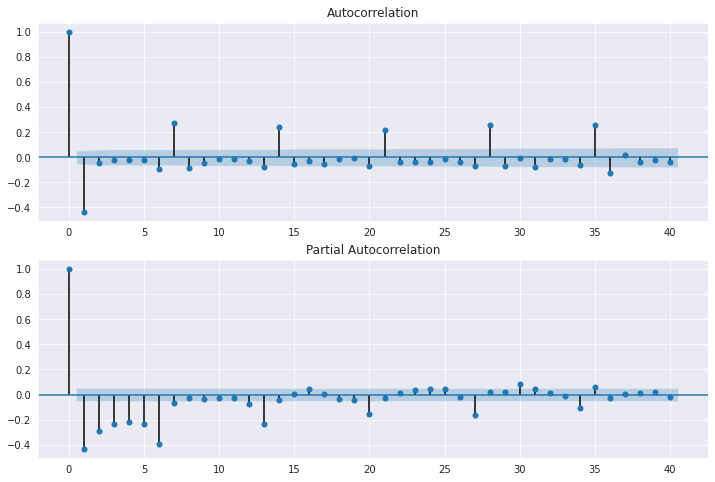

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)
plt.show()

Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists. Any time you see a regular pattern like that in one of these plots, you should suspect that there is some sort of significant seasonal thing going on. Then we should start to consider SARIMA to take seasonality into accuont

### Let's start with ARIMA

The first question is, how do we determine p, d, q?  

It's easy to determin I. In our case, we see the first order differencing make the ts stationary. I = 1.  

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use AR = 6  

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.  

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.  

Assuming an AR(s) model were computed, then I would suggest that the next step in identification is to estimate an MA model with s-1 lags in the uncorrelated errors derived from the regression. The parsimonious MA specification might be considered and this might be compared with a more parsimonious AR specification. Then ARMA models might also be analysed.

In [ ]:
arima_mod6 = sm.tsa.ARIMA(train_df.sales, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1369
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -4165.774
Method:                       css-mle   S.D. of innovations              5.070
Date:                Tue, 11 Aug 2020   AIC                           8347.548
Time:                        14:18:21   BIC                           8389.322
Sample:                    01-02-2013   HQIC                          8363.181
                         - 10-01-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0086      0.029      0.299      0.765      -0.048       0.065
ar.L1.D.sales    -0.8215      0.025    -33.067      0.000      -0.870      -0.773
ar.L2.D.sales    -0.7482      0.030    -

In [ ]:
resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

NormaltestResult(statistic=10.838575549909557, pvalue=0.004430300895686791)


Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Residual distribution')

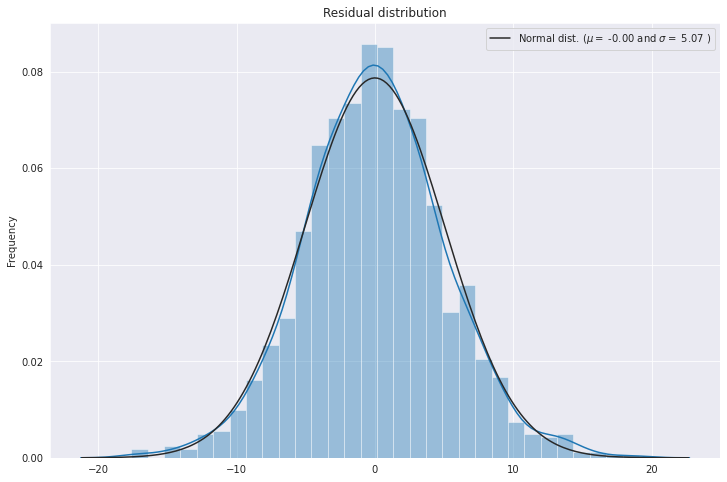

In [ ]:
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats
# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')
plt.show()

# plot the residuals

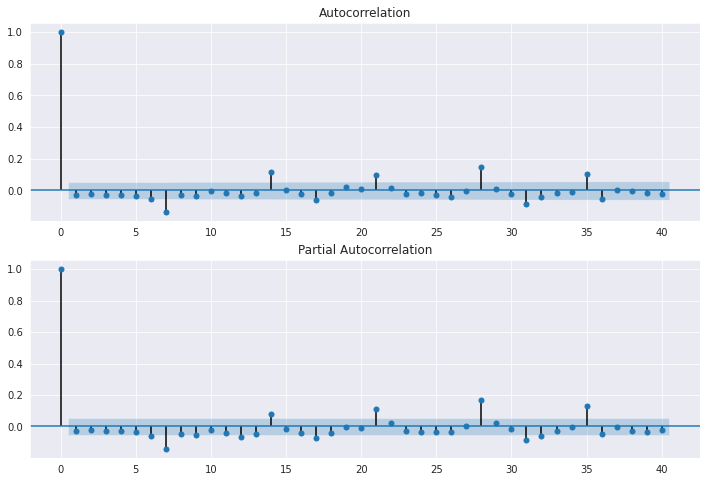

In [ ]:
# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

plt.show()

### Now let's do SARIMA

In [ ]:
# SARIMA
sarima_mod6 = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1370
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -4165.819
Date:                Tue, 11 Aug 2020   AIC                           8345.637
Time:                        14:31:58   BIC                           8382.190
Sample:                    01-01-2013   HQIC                          8359.317
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8215      0.024    -34.074      0.000      -0.869      -0.774
ar.L2         -0.7481      0.027    -27.334      0.000      -0.802      -0.694
ar.L3         -0.6810      0.029    -23.575      0.0

In [ ]:
resid = sarima_mod6.resid
print(normaltest(resid))

NormaltestResult(statistic=11.070822876108677, pvalue=0.00394458534954823)


Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Residual distribution')

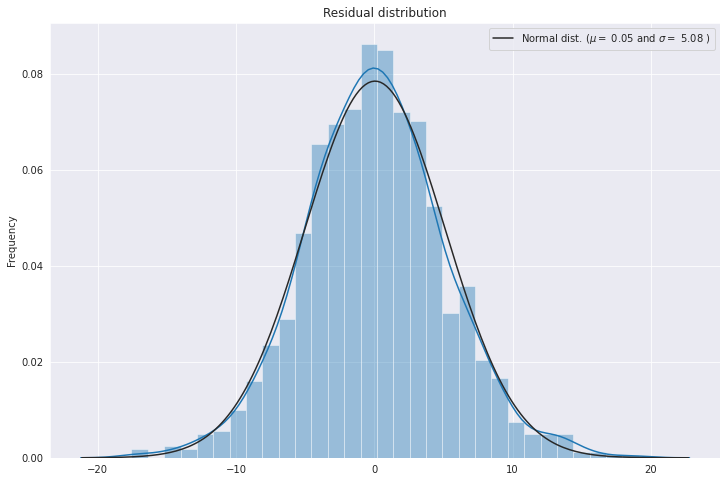

In [ ]:
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats
# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')
plt.show()

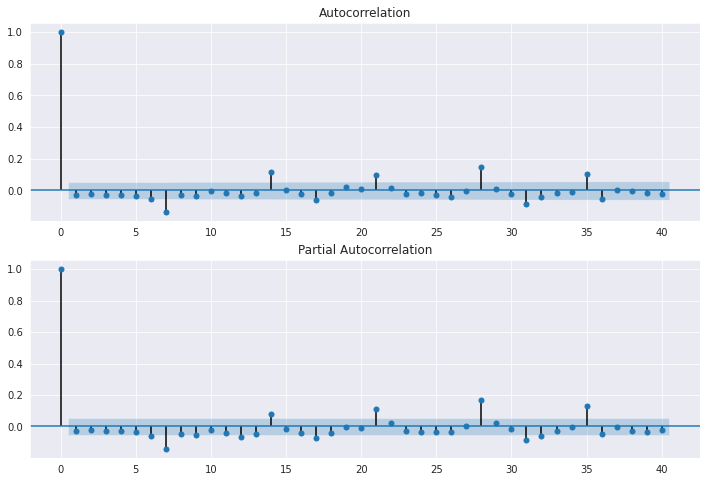

In [ ]:
# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)
plt.show()

### In sample validation

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Retail_sold')

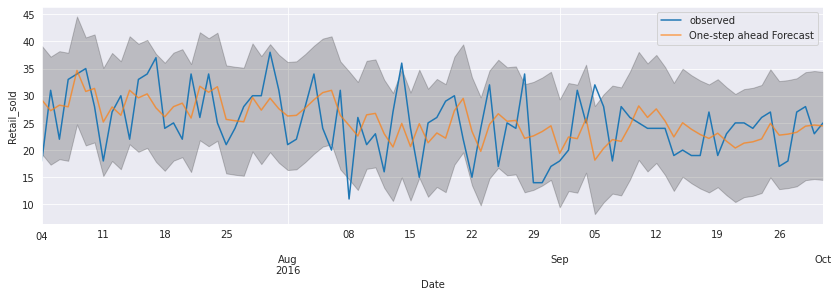

In [ ]:
pred = sarima_mod6.get_prediction(start = train_df.shape[0]-90, dynamic=False)
pred_ci = pred.conf_int()
ax = train_df[(train_df.shape[0]-90):]['sales'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

In [ ]:
# predict in the validation
pred_y = sarima_mod6.get_forecast(steps=90).predicted_mean
# rmse
math.sqrt(mean_squared_error(validate_df['sales'],pred_y)) # 6.83

6.832465338107396

### Out of sample prediction (30 days)

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Sales')

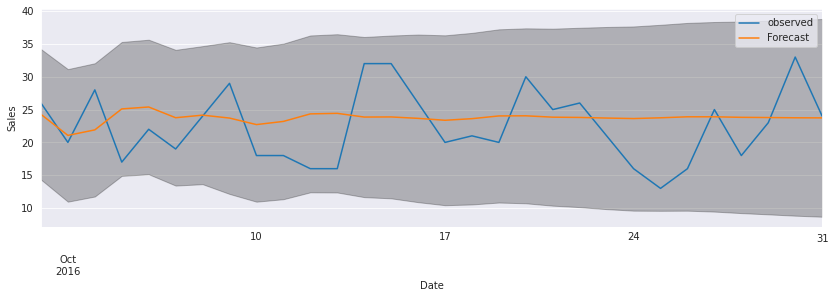

In [ ]:
# plot
pred_uc = sarima_mod6.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = validate_df[:30]['sales'].plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

## 2. Univariate time series: LSTM <a name="h2"></a>

Again, we use the item 1 from store 1 as an example to illustrate how LSTM works with one dimensional input.

In [ ]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size


The training data set has 3 years and 9 months data, and the validation data set has 3 months data.  

In [ ]:
# reading the input data
train_df = pd.read_csv('data/train.csv',parse_dates=['date'])
train_df = train_df[(train_df['store'] == 1) & (train_df['item'] == 1)]

all_train_data = train_df['sales'].values.astype(float)

train_data = all_train_data[:-90] # 3 years and 9 months
test_data = all_train_data[-90:] # last 90 days


First, let's scale the data

In [ ]:
# scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = scaler.fit_transform(test_data .reshape(-1, 1))
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

Set the training window to be 10 days. You can tune this parameter for better performance.  

In [ ]:
# moving window
train_window = 10

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
test_inout_seq = create_inout_sequences(test_data_normalized, train_window)


class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()

def model_train(epochs = 30):
    
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for i in range(1,epochs+1):
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        # validation
        with torch.no_grad():
            for seq, labels in test_inout_seq:
                y_test_pred = model(seq)
                test_loss = loss_function(y_test_pred.float(), labels)

        if i%5 == 0:
            print(f'Epoch {i} train loss: {single_loss.item():.4f} test loss: {test_loss.item():.4f}')

Train the model 

In [ ]:
model_train(epochs=15)

Epoch 5 train loss: 0.0035 test loss: 0.1086
Epoch 10 train loss: 0.0050 test loss: 0.0211
Epoch 15 train loss: 0.0007 test loss: 0.1013


Prediction in the validation set (next 90 days)

In [ ]:

fut_pred = 90

test_inputs = train_data_normalized[-train_window:].tolist()
# print(test_inputs)

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))


[0.07692307978868484, 0.025641025975346565, 0.12820513546466827, 0.1794871836900711, -0.3333333432674408, -0.28205129504203796, 0.1794871836900711, 0.23076923191547394, -0.025641025975346565, 0.07692307978868484]


Plot prediction calibration

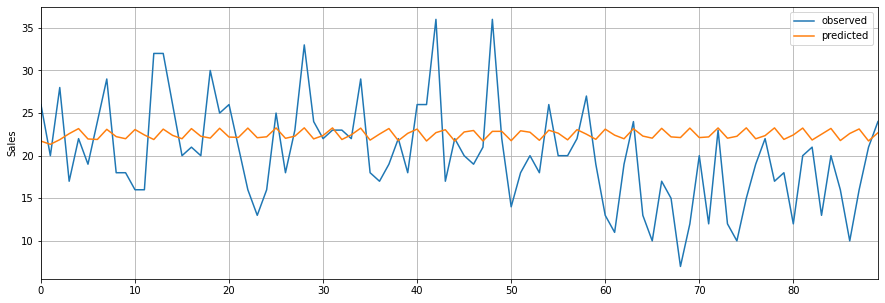

In [ ]:
# plot calibration
plt.ylabel('Sales')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(test_data,label="observed")
plt.plot(actual_predictions,label="predicted")
plt.legend()
plt.show()


Calculate prediction RMSE

In [ ]:
# rmse
math.sqrt(mean_squared_error(test_data,actual_predictions))

6.179230073123029

## 3. Multivariate time series: LSTM <a name="h3"></a>

In [ ]:
from numpy import array

Set training window 

In [ ]:
window = 30 # time window in model training

Prepare data

In [ ]:
train_df = pd.read_csv('data/train.csv',parse_dates=['date'])
train_df['sales'] = train_df['sales'].values.astype(float)

train_data = train_df[train_df['date']<'2016-10-02'] # 3 years and 9 months
test_data = train_df[train_df['date']>'2016-10-01'] # last 90 days


Reshape data to wide format

In [ ]:
def to_wide(data):

    data['id'] = 'store '+ data['store'].astype(str) + ', item ' + data['item'].astype(str)
    data = data.drop(['store','item'],axis=1)

    data_wide = data.pivot_table(index='date',
                                 columns='id',
                                 values='sales')
    return data_wide.values

train_wide = to_wide(train_data)
test_wide = to_wide(test_data)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Scale data

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_wide.reshape(-1, train_wide.shape[-1])).reshape(train_wide.shape)
test_data_normalized = scaler.fit_transform(test_wide.reshape(-1, test_wide.shape[-1])).reshape(test_wide.shape)

Get sequences of data

In [ ]:
def to_sequences(sequences,n_steps_in,n_steps_out):
    X, y = list(), list()

    for i in range(len(sequences)):

        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]

        X.append(seq_x)
        y.append(seq_y)

    return array(X), array(y)

train_X, train_y=to_sequences(train_data_normalized,window,1)
test_X, test_y=to_sequences(test_data_normalized,window,1)

train_X = torch.DoubleTensor(train_X) # 1340, window, 500
train_y = torch.DoubleTensor(train_y) # 1340, 1, 500
test_X = torch.DoubleTensor(test_X) # 60, window, 500
test_y = torch.DoubleTensor(test_y) # 60, 1, 500


Define multivariate LSTM model

In [ ]:

class LSTM(nn.Module):
    def __init__(self, input_size=500, hidden_layer_size=100, output_size=500):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,window,self.hidden_layer_size),
                            torch.zeros(1,window,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out)
        return predictions[:,0,:]


Define training function

In [ ]:

def model_train(epochs = 30):
    model = LSTM()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for i in range(1,epochs+1):

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, window, model.hidden_layer_size),
                        torch.zeros(1, window, model.hidden_layer_size))

        y_pred = model(train_X.float())

        single_loss = loss_function(y_pred.float(), train_y.view(len(train_y),500).float())
        single_loss.backward()
        optimizer.step()

        # validation
        with torch.no_grad():
            y_test_pred = model(test_X.float())
            test_loss = loss_function(y_test_pred.float(), test_y.view(len(test_y),500).float())

        if i%5 == 0:
            print(f'Epoch {i} train loss: {single_loss.item():.4f} test loss: {test_loss.item():.4f}')
    return model


In [ ]:
model = model_train(epochs = 30)

Epoch 5 train loss: 0.1268 test loss: 0.2518
Epoch 10 train loss: 0.1027 test loss: 0.2601
Epoch 15 train loss: 0.0901 test loss: 0.2608
Epoch 20 train loss: 0.0853 test loss: 0.2600
Epoch 25 train loss: 0.0826 test loss: 0.2629
Epoch 30 train loss: 0.0792 test loss: 0.2658


Define prediction function

In [ ]:

def predict(fut_pred = 90):

    # prediction in the validation set

    test_inputs = train_X[-1][-window:]

    model.eval()

    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-window:].float()).view(1,-1,500)
        with torch.no_grad():
            model.hidden = (torch.zeros(1, window, model.hidden_layer_size),
                            torch.zeros(1, window, model.hidden_layer_size))
            test_inputs = torch.cat((test_inputs.float(),model(seq)),0)

    actual_predictions = scaler.inverse_transform(np.array(test_inputs[window:] ))
    return actual_predictions


Get prediction

In [ ]:
actual_predictions = predict(fut_pred = 90)
pred_1_1 = actual_predictions[:,0]

observed = test_data['sales'][test_data['id']=='store 1, item 1'].values


Plot calibration

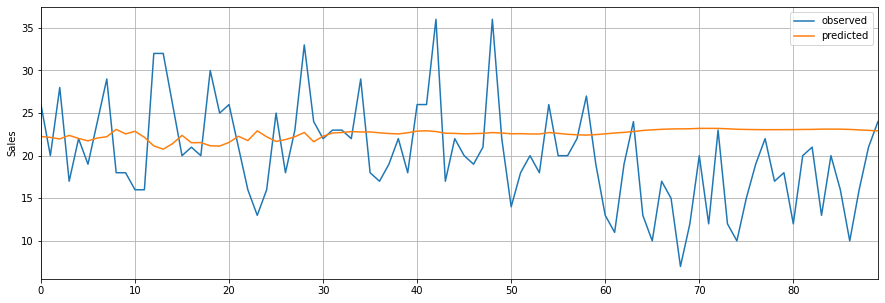

In [ ]:
plt.ylabel('Sales')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(observed,label="observed")
plt.plot(pred_1_1,label="predicted")
plt.legend()
plt.show()

Calculate prediction RMSE

In [ ]:

# rmse
math.sqrt(mean_squared_error(pred_1_1,observed)) # 5.94


6.501066389335672